In [1]:
import numpy as np
import cv2 # OpenCV
import matplotlib
import matplotlib.pyplot as plt
import math
import collections
import time
import json

In [2]:
# iscrtavanje slika u notebook-u
%matplotlib inline
# prikaz vecih slika
matplotlib.rcParams['figure.figsize'] = 16,12

In [3]:
# keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

Using TensorFlow backend.


In [4]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret, image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin

def invert(image):
    return 255-image

def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def dilate(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

In [5]:
def resize_region(region):
    return cv2.resize(region, (28, 28), interpolation=cv2.INTER_NEAREST)

In [6]:
def select_roi(image_orig, image_bin):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po X osi
    regions_array = []
    print(len(contours))
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) # koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if h < 100 and h > 40 and w > 20 and w<70:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # oznaciti region pravougaonikom na originalnoj slici sa rectangle funkcijom
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in regions_array]
    return image_orig, sorted_regions

In [7]:
def scale_to_range(image):
    return image/255

In [8]:
def matrix_to_vector(image):
    return image.flatten()

In [9]:
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann

In [10]:
def convert_output(alphabet):
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

In [11]:
def create_ann(output_size):
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(output_size, activation='sigmoid'))
    return ann

In [12]:
def train_ann(ann, X_train, y_train, epochs):
    X_train = np.array(X_train, np.float32) # dati ulaz
    y_train = np.array(y_train, np.float32) # zeljeni izlazi na date ulaze
    
    print("\nTraining started...")
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)
    ann.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0, shuffle=False)
    print("\nTraining completed...")
    return ann

In [13]:
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

In [14]:
def display_result(outputs, alphabet):
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

13


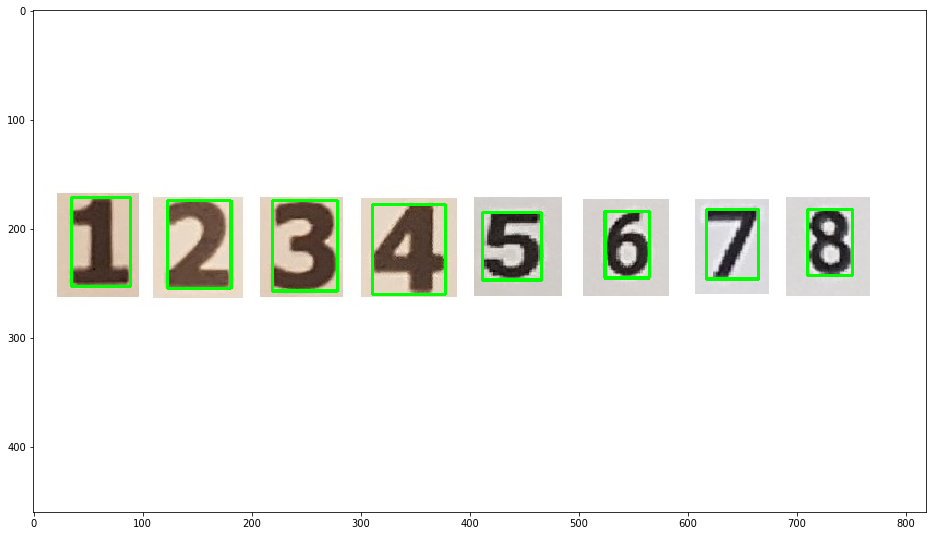

In [15]:
#obucavanje
#priprema slike sa brojevima
image_color = load_image('images/brojevi.jpg')
img = image_bin(image_gray(image_color))
img_bin = erode(dilate(img))
selected_regions, numbers = select_roi(image_color.copy(), img_bin)
display_image(selected_regions)

In [16]:
#treniranje
alphabet = [1, 2, 3, 4, 5, 6, 7, 8]

inputs = prepare_for_ann(numbers)
outputs = convert_output(alphabet)
ann = create_ann(output_size=8)
ann = train_ann(ann, inputs, outputs, epochs=2000)


Training started...

Training completed...


In [17]:
result = ann.predict(np.array(inputs[1:3], np.float32))
print(result)
print("\n")
print(display_result(result, alphabet))

[[0.01909032 0.96736735 0.01826262 0.00752375 0.01215276 0.00401855
  0.01978073 0.01400587]
 [0.01147506 0.01777533 0.96703815 0.01016212 0.01647004 0.00276464
  0.01280898 0.01964352]]


[2, 3]


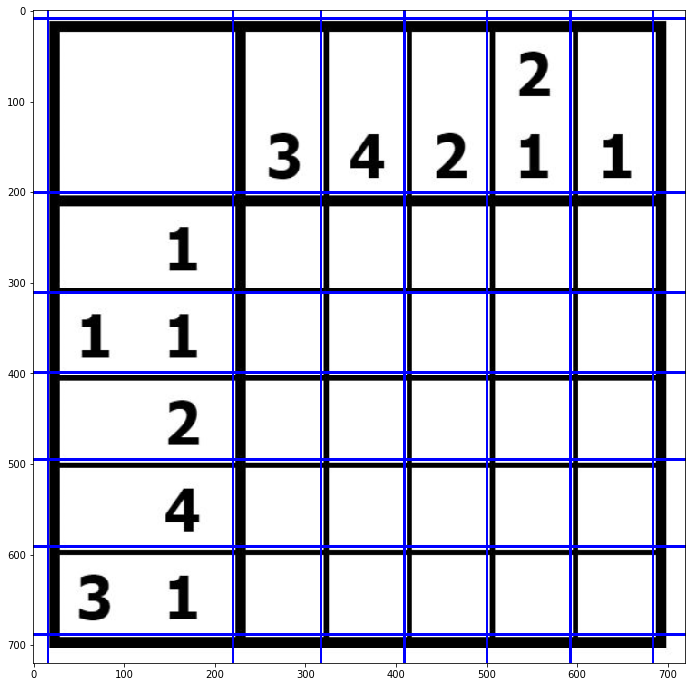

In [18]:
img = cv2.imread('images/nonogram7.jpg')# ucitavanje slike sa diska
img = cv2.resize(img, (720,720)) 
slikica = img.copy()
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # konvertovanje iz BGR u RGB model boja (OpenCV ucita sliku kao BGR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
slikica2 = image_bin(gray.copy())
slikicaa = erode(dilate(slikica2))
edges = cv2.Canny(gray,90,150,apertureSize = 3)
kernel = np.ones((3,3),np.uint8)
edges = cv2.dilate(edges,kernel,iterations = 3)
#kernel = np.ones((5,5),np.uint8)
#edges = cv2.erode(edges,kernel,iterations = 1)
lines = cv2.HoughLines(edges, 1,np.pi/180, 420)
vert_linije=[]
horiz_linije=[]
for line in lines:
    rho,theta=line[0]
    if(np.sin(theta)==1):
        horiz_linije.append(line)
    elif(np.sin(theta)==0):
        vert_linije.append(line)
filtrirane_linije=[]
posljednji_rho=None
vert_linije.sort(key=lambda element: element[0][0])
for line in vert_linije:
    rho,theta=line[0]
    if posljednji_rho==None:
        filtrirane_linije.append(line)
        posljednji_rho=rho
    else:
        if (rho-posljednji_rho>20):
            posljednji_rho=rho
            filtrirane_linije.append(line)
posljednji_rho=None
horiz_linije.sort(key=lambda element: element[0][0])
for line in horiz_linije:
    rho,theta=line[0]
    if posljednji_rho==None:
        posljednji_rho=rho
        filtrirane_linije.append(line)
    else:
        if (rho-posljednji_rho>20):
            posljednji_rho=rho
            filtrirane_linije.append(line)
for line in filtrirane_linije:
    rho,theta=line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
plt.imshow(img)

In [19]:
import math

In [20]:
def select_roi_nonogram(image_orig, image_bin, broj):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po X osi
    regions_array = []
    print(len(contours))
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) # koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if h < 90 and h > 10 and w > 10 and w<50  and area>130:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # oznaciti region pravougaonikom na originalnoj slici sa rectangle funkcijom
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
    if broj==1:
        regions_array = sorted(regions_array, key=lambda x: x[1][0])
    else:
        regions_array = sorted(regions_array, key=lambda y: y[1][0])
    sorted_regions = [region[0] for region in regions_array]
    return image_orig, sorted_regions

In [21]:
intersections=[]
p=1
for i in range(len(filtrirane_linije)):
    rho1, theta1 = filtrirane_linije[i][0]
    for ii in range(p,len(filtrirane_linije)):
        rho2, theta2 = filtrirane_linije[ii][0]
        if((np.sin(theta1)==1 and np.sin(theta2)==0) or (np.sin(theta1)==0 and np.sin(theta2)==1)):
            A = np.array([
                [np.cos(theta1), np.sin(theta1)],
                [np.cos(theta2), np.sin(theta2)]
            ])
            b = np.array([[rho1], [rho2]])
            tacka = np.linalg.solve(A, b)
            intersections.append(tacka)
    p=p+1
    if(p==len(filtrirane_linije)):
        break
korjen=math.sqrt(len(intersections))
korjen=int(korjen)
pravougaonici=[]
br=0
bra=1
for i in range((korjen-1)**2):
        if(br!=0 and bra==korjen):
            bra=1
            br=br+1
        pravougaonici.append([intersections[br],intersections[br+korjen],intersections[br+1],intersections[br+korjen+1]])
        br=br+1
        bra=bra+1
zadnji_pravougaonik=pravougaonici[-1]#iskoristicemo ga za mjeru koliko brojeva moze stati u pravougaonike
rows_pravougaonici=[]
columns_pravougaonici=[]
rows_regions_array=[]
columns_regions_array=[]
broj_rows=[]
broj_columns=[]
brojac=0
for i in pravougaonici:
    if (brojac>0 and brojac<(korjen-1)):
        rows_pravougaonici.append(i)
    if(brojac%(korjen-1)==0 and brojac>0):
        columns_pravougaonici.append(i)
    brojac=brojac+1
print("ROWS PRAVOUGAONICI")
rows_br=int((rows_pravougaonici[0][1][0]-rows_pravougaonici[0][0][0])/(zadnji_pravougaonik[1][0]-zadnji_pravougaonik[0][0]))
print("U rows pravougaonicima se moze nalaziti brojeva:"+str(rows_br))
for i in rows_pravougaonici:
    image=img[int(i[0][1]):int(i[2][1]), int(i[0][0]):int(i[1][0])]
    slika = image_bin(image_gray(image))
    slika_bin=erode(dilate(slika))
    selektovani_region, brojevi = select_roi_nonogram(image.copy(), slika_bin, 1)
    broj_rows.append(len(brojevi))
    for i in range(len(brojevi)):
        resize_broj = resize_region(brojevi[i])
        rows_regions_array.append(resize_broj)
    
print("COLUMNS PRAVOUGAONICI")
columns_br=int((columns_pravougaonici[0][2][1]-columns_pravougaonici[0][0][1])/(zadnji_pravougaonik[2][1]-zadnji_pravougaonik[0][1]))
print("U columns pravougaonicima se moze nalaziti brojeva:"+str(columns_br))
for i in columns_pravougaonici:
    image=img[int(i[0][1]):int(i[2][1]), int(i[0][0]):int(i[1][0])]
    slika = image_bin(image_gray(image))
    slika_bin=erode(dilate(slika))
    selektovani_region, brojevi = select_roi_nonogram(image.copy(), slika_bin, 2)
    broj_columns.append(len(brojevi))
    for i in range(len(brojevi)):
        resize_broj = resize_region(brojevi[i])
        columns_regions_array.append(resize_broj)
    

ROWS PRAVOUGAONICI
U rows pravougaonicima se moze nalaziti brojeva:2
3
3
3
4
4
COLUMNS PRAVOUGAONICI
U columns pravougaonicima se moze nalaziti brojeva:1
4
5
4
5
4


In [22]:
test_inputs_rows =  prepare_for_ann(rows_regions_array)
result_rows = ann.predict(np.array(test_inputs_rows, np.float32))

In [23]:
redovi=display_result(result_rows, alphabet)
print(display_result(result_rows, alphabet))
print(broj_rows)
lista_redovi=[]
brojac=-1
brojac2=-1
podlista=[]
for i in range(len(redovi)):
    if brojac==-1:
        brojac2=brojac2+1
        brojac=broj_rows[brojac2]
        podlista=[]
    if brojac==0:
        brojac2=brojac2+1
        brojac=broj_rows[brojac2]
        lista_redovi.append(podlista)
        podlista=[]
    podlista.append(redovi[i])
    brojac=brojac-1
    if (i+1)==len(redovi):
        lista_redovi.append(podlista)
print(lista_redovi)

[1, 1, 1, 2, 4, 3, 1]
[1, 2, 1, 1, 2]
[[1], [1, 1], [2], [4], [3, 1]]


In [24]:
print(result_rows)

[[0.93015385 0.01304072 0.0067414  0.01262286 0.00953662 0.01873738
  0.02021953 0.00319299]
 [0.9498334  0.01148954 0.00941268 0.01716152 0.00671712 0.01415527
  0.0194858  0.0028787 ]
 [0.92767835 0.01298401 0.00665894 0.01307303 0.00918776 0.01954567
  0.02125216 0.00326744]
 [0.02599329 0.71303314 0.01316467 0.01164404 0.00722888 0.00477886
  0.04462075 0.01648328]
 [0.01146117 0.00518525 0.00687131 0.9444819  0.00589132 0.02004004
  0.01663151 0.0102759 ]
 [0.0076184  0.01737776 0.79881084 0.01015776 0.01401931 0.00362787
  0.01872611 0.03260857]
 [0.9321283  0.01400813 0.00696924 0.01258424 0.00938421 0.01991388
  0.01961556 0.00306955]]


In [25]:
test_inputs_cols =  prepare_for_ann(columns_regions_array)
result_cols = ann.predict(np.array(test_inputs_cols, np.float32))
print(display_result(result_cols, alphabet))
print(broj_columns)
kolone=display_result(result_cols, alphabet)
lista_kolone=[]
brojac=-1
brojac2=-1
podlista=[]
for i in range(len(kolone)):
    if brojac==-1:
        brojac2=brojac2+1
        brojac=broj_columns[brojac2]
        podlista=[]
    if brojac==0:
        brojac2=brojac2+1
        brojac=broj_columns[brojac2]
        lista_kolone.append(podlista)
        podlista=[]
    podlista.append(kolone[i])
    brojac=brojac-1
    if (i+1)==len(kolone):
        lista_kolone.append(podlista)
print(lista_kolone)

[3, 4, 2, 2, 1, 1]
[1, 1, 1, 2, 1]
[[3], [4], [2], [2, 1], [1]]


In [26]:
from itertools import combinations_with_replacement,permutations
class Nonogram():
    def __init__(self,rows,columns):
        self.rows=rows
        self.columns=columns
        self.nono=[]
        row=[]
        for i in range(len(self.columns)):
            row.append(0)
        for i in range(len(self.rows)):
            self.nono.append(row)
    def isBroken(self):
        """
        for i in range(len(self.rows)):
            checkRow=[]
            br=0
            for ii in self.nono[i]:
                if ii==1:
                    br=br+1
                elif br!=0 and ii==0:
                    checkRow.append(br)
                    br=0
            if(len(checkRow)>len(self.rows[i])):
                return True
            for i in range(len(self.rows[i])):
                if checkRow[i]>self.rows[i][i]:
                    return True
        """
        for i in range(len(self.columns)):
            column=[]
            for iii in self.nono:
                column.append(iii[i])
            #print(column)
            checkRow=[]
            br=0
            for ii in column:
                if ii==1:
                    br=br+1
                elif br!=0 and ii==0:
                    checkRow.append(br)
                    br=0
            if br!=0:
                checkRow.append(br)
            #print(checkRow)
            if(len(checkRow)>len(self.columns[i])):
                return True
            for ii in range(len(self.columns[i])):
                try:
                    #print(checkRow[ii],self.columns[i][ii])
                    if checkRow[ii]>self.columns[i][ii]:
                        return True
                except:
                    pass
        return False
    def isSolved(self):
        #treba provjeriti da li je broken
        brojac1=0
        brojac2=0
        for i in self.nono:
            for ii in i:
                if ii==1:
                    brojac1=brojac1+1
        for i in self.rows:
            for ii in i:
                brojac2=brojac2+ii
        return brojac1==brojac2
    def rowPermutations(self,row,duzina):
        trenutniRed=[]
        for i in row:
            for a in range(i):
                trenutniRed.append(1)
            trenutniRed.append(0)
        trenutniRed.pop()
        br_praznina=duzina-len(trenutniRed)
        praznine=[0]
        for i in range(len(row)):
            praznine.append(0)
        lista=list(range(0,br_praznina+1))
        perm = combinations_with_replacement(lista,len(praznine))
        permutacije=[]
        for i in perm:
            if (sum(i)==br_praznina):
                permutacije.append(i)
        sve_perm=[]
        for i in permutacije:
            perma=[]
            for a in i:
                perma.append(a)
            #print(perma)
            permem = permutations(perma)
            for dod in permem:
                #print(ii)
                sve_perm.append(dod)
        preciscene_perm=[]
        for i in sve_perm:
            if not(i in preciscene_perm):
                preciscene_perm.append(i)
        izbori=[]
        br = 1
        for i in preciscene_perm:
            izbor=[]
            brojac=0
            for ii in i:
                for iii in range(ii):
                    izbor.append(0)
                if (brojac<=len(i)-2):
                    for iiii in range(row[brojac]):
                        izbor.append(1)
                    if (brojac<len(i)-2):
                        izbor.append(0)
                brojac=brojac+1
            izbori.append({br:izbor})
            br=br+1
        return izbori

In [27]:
import copy
class Stack:
    "A container with a last-in-first-out (LIFO) queuing policy."
    def __init__(self):
        self.list = []

    def push(self,item):
        "Push 'item' onto the stack"
        self.list.append(item)

    def pop(self):
        "Pop the most recently pushed item from the stack"
        return self.list.pop()

    def isEmpty(self):
        "Returns true if the stack is empty"
        return len(self.list) == 0
def depthFirstSearch(nono):
    struktura=Stack() #lifo za dfs
    prosao=[]
    prolazi = []
    struktura.push([])
    prazanNono=nono.nono
    while struktura.isEmpty()==False:
        prolazi=copy.deepcopy(struktura.pop())
        # if da li je to rjesenje? ako jeste vrati ga
        if len(prolazi)==len(nono.nono):
            nono.nono=prazanNono
            for i in range(len(prolazi)):
                djeca = nono.rowPermutations(nono.rows[i], len(nono.nono[0]))
                for dijetee in djeca:
                    if (list(dijetee.keys())[0] == prolazi[i]):
                        nono.nono[i] = dijetee[prolazi[i]]
            if nono.isSolved() and not(nono.isBroken()):
                return nono
        #else onda dodaj dijecu tj. moguce sl poteze sa tog polja u stablo pretrage
        else:
            djeca=nono.rowPermutations(nono.rows[len(prolazi)],len(nono.nono[0]))
            for dijete in djeca:
                prolazi.append(list(dijete.keys())[0])
                nasao=False
                for korak in prosao:
                    if prolazi==korak:
                        nasao=True
                        break
                if nasao==False:
                    listica=[]
                    for i in prolazi:
                        listica.append(i)
                    prosao.append(copy.deepcopy(listica))
                    nono.nono=prazanNono
                    for i in range(len(prolazi)):
                        djetasce = nono.rowPermutations(nono.rows[i], len(nono.nono[0]))
                        for dijetee in djetasce:
                            if(list(dijetee.keys())[0]==prolazi[i]):
                                nono.nono[i] = dijetee[prolazi[i]]
                    #if not(nono.isBroken()):
                    struktura.push(copy.deepcopy(listica))
                prolazi.pop()
    print(prosao)
    return nono

In [28]:
nono =Nonogram(lista_redovi,lista_kolone)
depthFirstSearch(nono)
print(nono.isBroken())
print(nono.isSolved())
for i in nono.nono:
    print(i)
print(nono.nono[2][0])

False
True
[0, 0, 0, 1, 0]
[0, 1, 0, 1, 0]
[1, 1, 0, 0, 0]
[1, 1, 1, 1, 0]
[1, 1, 1, 0, 1]
1


In [29]:
def permutationas(values, row, n=0):
    if values and values[0]:
        current, *other = values
        for i in range(len(row)-sum(other)-len(other)+1-current):
            if 1 not in row[i:i+current]:
                for j in permutationas(other, row[i+current+1:], 1):
                    yield [1]*(i+n) + [2]*current + j
    else:
        yield []
        
def solve_row(values, row):
    valid_permutations = []
    for permutation in permutationas(values, row):
        permutation += [1]*(len(row)-len(permutation))
        for n1, n2 in zip(row, permutation):
            if n1>0 and n1 != n2:
                break
        else:
            valid_permutations.append(permutation)

    new_row = valid_permutations[0]
    for permutation in valid_permutations[1:]:
        new_row = [n if n==r else 0 for n, r in zip(new_row, permutation)]
                
    return new_row
    
def solve(row_values, col_values, grid):
    changed = True
    while changed:
        changed = False
        for y, row_value in enumerate(row_values):
            row = solve_row(row_value, grid[y])
            for x, cell in enumerate(row):
                if cell and grid[y][x] != cell:
                    changed = True
                grid[y][x] = cell
                    
        for x, col_value in enumerate(col_values):
            col = solve_row(col_value, [row[x] for row in grid])
            for y, cell in enumerate(col):
                if cell and grid[y][x] != cell:
                    changed = True
                grid[y][x] = cell

def backtracking(width, height, rows, columns):

    grid = [[0]*width for i in range(height)]
    
    solve(rows, columns, grid)
    
    nonogram = Nonogram(lista_redovi, lista_kolone)
    nonogram_kopija = []
    redovi = []
    
    for i in grid:
        for a in i:
            if a==1:
                redovi.append(0)
            else:
                redovi.append(1)
        nonogram_kopija.append(redovi)
        redovi = []
            
    nonogram.nono = nonogram_kopija
    print(nonogram.nono)

    return nonogram.nono
    
za_crtanje = backtracking(len(lista_redovi), len(lista_kolone), lista_redovi, lista_kolone)

[[0, 0, 0, 1, 0], [0, 1, 0, 1, 0], [1, 1, 0, 0, 0], [1, 1, 1, 1, 0], [1, 1, 1, 0, 1]]


In [ ]:
import turtle
 
def draw_box(t,x,y,size,fill_color):
    t.penup() # no drawing!
    t.goto(x,y) # move the pen to a different position
    t.pendown() # resume drawing
 
    t.fillcolor(fill_color)
    t.begin_fill()  # Shape drawn after this will be filled with this color!
 
    for i in range(0,4):
        t.forward(size) # move forward
        t.right(90) # turn pen right 90 degrees
 
    t.end_fill() # Go ahead and fill the rectangle!
 
 
def draw_nonogram(crtanje, board):
    square_color = "black"
    start_x = 0 
    start_y = 0 
    box_size = 30 # pixel size
    for i in range(len(crtanje)):
        for j in range(len(crtanje)):
            square_color = 'black' if crtanje[i][j] == 1 else 'white'
            draw_box(board,start_x+j*box_size,start_y-i*box_size,box_size,square_color)

try:           
    board1 = turtle.Turtle()
except:
    board1 = turtle.Turtle()
draw_nonogram(nono.nono, board1)
turtle.done()
try:           
    board2 = turtle.Turtle()
except:
    board2 = turtle.Turtle()
draw_nonogram(za_crtanje, board2)
turtle.done()

In [ ]:
def testiranje_algoritama():
    f = open("images/nonogrami.txt", "r")
    for x in f:
        try:
            tx = x.split("|")
            #print(tx[1])
            lista=json.loads(tx[1])
            #print(lista)
            lista_redovi=lista[0]
            #print(lista_redovi)
            lista_kolone=lista[1]
            #print(lista_kolone)
            nono1 =Nonogram(lista_redovi,lista_kolone)
            koliko_bektreking=0
            start = time.time()
            backtracking(len(lista_redovi), len(lista_kolone), lista_redovi, lista_kolone)
            end = time.time()
            koliko_bektreking=end-start
            koliko_dfs=0
            start = time.time()
            depthFirstSearch(nono1)
            end = time.time()
            koliko_dfs=end-start
            print("----------------------------------")
            if koliko_bektreking<koliko_dfs:
                print("BEKTREKING")
            else:
                print("DFS")
        except:
            print(x)
testiranje_algoritama()